This Notebook intends to compare our trained models and the ensemble learning technique, with huggingface's model available on huggingface. Article reference [here](https://www.sciencedirect.com/science/article/pii/S1544612324000096)

# Data Import

In [3]:
import pandas as pd
from datasets import load_dataset


In [4]:
social_data = load_dataset("ESGBERT/social_2k")['train'].to_pandas().rename(columns={'soc': 'esg_category'})
gov_data = load_dataset("ESGBERT/governance_2k")['train'].to_pandas().rename(columns={'gov': 'esg_category'})
env_data = load_dataset("ESGBERT/environmental_2k")['train'].to_pandas().rename(columns={'env': 'esg_category'})

In [5]:
social_data['esg_category'] = social_data['esg_category'].map({1: 'social', 0: 'non-esg'}).fillna(social_data['esg_category'])
gov_data['esg_category'] = gov_data['esg_category'].map({1: 'gouvernance', 0: 'non-esg'}).fillna(gov_data['esg_category'])
env_data['esg_category'] = env_data['esg_category'].map({1: 'environnemental', 0: 'non-esg'}).fillna(env_data['esg_category'])

labels = ['social', 'gouvernance', 'environnemental']

# sample 150 social, 150 governance, 150 environmental from each dataset and 50 non-esg from each dataset
test_data = pd.concat([social_data[social_data['esg_category'] == 'social'].sample(150,random_state=42),
                       gov_data[gov_data['esg_category'] == 'gouvernance'].sample(150,random_state=42),
                       env_data[env_data['esg_category'] == 'environnemental'].sample(150,random_state=42),
                       social_data[social_data['esg_category'] == 'non-esg'].sample(50,random_state=42),
                       gov_data[gov_data['esg_category'] == 'non-esg'].sample(50,random_state=42),
                       env_data[env_data['esg_category'] == 'non-esg'].sample(50,random_state=42)], ).drop(columns=['Unnamed: 0'])
test_data.reset_index(drop=True, inplace=True)
test_data.to_csv("ESGBert_test_data.csv", index=False)
test_data

,text,esg_category
0,We have a dedicated team who manage a portfoli...,social
1,A listed entity should disclose whether it has...,social
2,Our suppliers' activities support our overall ...,social
3,This year we raised the bar on our environment...,social
4,"the BGC’s AdTech forum, which includes a parti...",social
...,...,...
595,The information reported by the Company concer...,non-esg
596,One measure of loyalty is the employees’ years...,non-esg
597,The Board has established a remuneration commi...,non-esg
598,This development offers additional growth pote...,non-esg


# CB-512 testing

In [1]:
import pandas as pd
import utilsNb as utils
import torch
import transformers
import numpy as np

from sklearn.metrics import classification_report
from transformers import pipeline
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformers.logging.set_verbosity_error()


In [14]:
from easynmt import EasyNMT
translate_model = EasyNMT('opus-mt',cache_folder="./NMT_model_cache")

test_data["text"] = test_data["text_en"].apply(lambda x: translate_model.translate(x, source_lang='fr', target_lang='en'))

d:\azeem\Documents\UNIGE\MSc CS\sentiment-analysis-for-msci-rating\env\Lib\site-packages\transformers\generation\utils.py:1353: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Model cb-512 loaded.


100%|██████████| 600/600 [00:48<00:00, 12.42it/s]


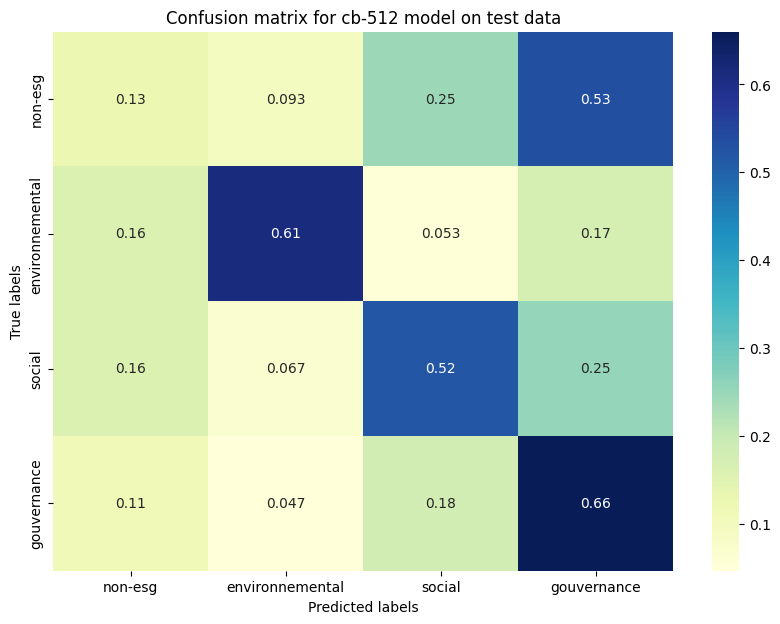

                 precision    recall  f1-score   support

environnemental       0.75      0.61      0.67       150
    gouvernance       0.41      0.66      0.50       150
        non-esg       0.23      0.13      0.16       150
         social       0.52      0.52      0.52       150

       accuracy                           0.48       600
      macro avg       0.48      0.48      0.47       600
   weighted avg       0.48      0.48      0.47       600



In [15]:
model_cb, tokenizer_base = utils.load_sd_model("cb-512",model_sd_path='../models/model-cb/run4/models/state_dict/cb_sd.pt')
df_res = utils.predict_df(test_data, model_cb, tokenizer_base, tokenizer_max_len=512, return_prediction_only=True, column_name="cb_pred")

utils.print_confusion_matrix(df_res["esg_category"], df_res['cb_pred'], title = "Confusion matrix for cb-512 model on test data")
report = classification_report(df_res['esg_category'], df_res['cb_pred'], zero_division=0)
print(report)

In [17]:
from src import ESGPredictor
cb_model_path = "../models/model-cb/run4/models/state_dict/cb_sd.pt"
cbl_model_path = "../models/model-cbl/run1/models/state_dict/cb_large_model1_sd.pt"
cbl_1024_model_path = "../models/model-cbl-long/run1/models/state_dict/cbl_model_long_sd.pt"

model = ESGPredictor(cb_model_path, cbl_model_path, cbl_1024_model_path)

Model cb-512 loaded.
Model cbl-512 loaded.
Model cbl-1024 loaded.


In [19]:
df_res = model.predict_df(test_data)

Predicting  : 100%|██████████| 600/600 [06:27<00:00,  1.55it/s]


In [20]:
df_res

,text_en,esg_category,text,esg_predictor
0,We have a dedicated team who manage a portfoli...,social,We have a dedicated team who manage a portfoli...,gouvernance
1,A listed entity should disclose whether it has...,social,A listed entity should disclose where it has a...,social
2,Our suppliers' activities support our overall ...,social,Our requests' activities support our overall b...,gouvernance
3,This year we raised the bar on our environment...,social,This year we thought the bar on our environmen...,environnemental
4,"the BGC’s AdTech forum, which includes a parti...",social,"the BGC的s AdTech forum, which includes a parti...",gouvernance
...,...,...,...,...
595,The information reported by the Company concer...,non-esg,The information reported by the Company concer...,gouvernance
596,One measure of loyalty is the employees’ years...,non-esg,One measure of loyalty is the employees-years ...,gouvernance
597,The Board has established a remuneration commi...,non-esg,The Board has established a compensation commi...,gouvernance
598,This development offers additional growth pote...,non-esg,This development offers additional growth pote...,social


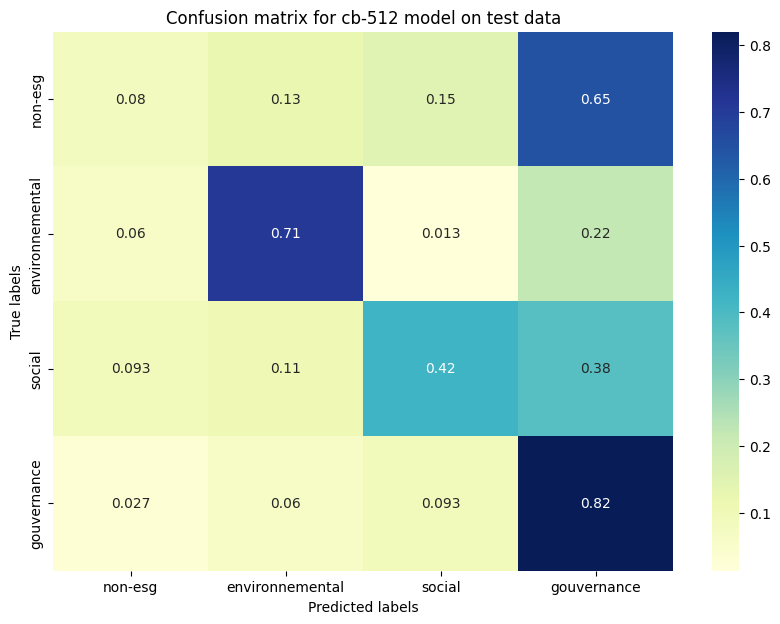

In [21]:
utils.print_confusion_matrix(df_res["esg_category"], df_res['esg_predictor'], title = "Confusion matrix for cb-512 model on test data")
report = classification_report(df_res['esg_category'], df_res['esg_predictor'], zero_division=0)

In [23]:
print(report)

                 precision    recall  f1-score   support

environnemental       0.71      0.71      0.71       150
    gouvernance       0.40      0.82      0.53       150
        non-esg       0.31      0.08      0.13       150
         social       0.62      0.42      0.50       150

       accuracy                           0.51       600
      macro avg       0.51      0.51      0.47       600
   weighted avg       0.51      0.51      0.47       600



# ESGBert dataset

In [6]:
test_data

,text,esg_category
0,We have a dedicated team who manage a portfoli...,social
1,A listed entity should disclose whether it has...,social
2,Our suppliers' activities support our overall ...,social
3,This year we raised the bar on our environment...,social
4,"the BGC’s AdTech forum, which includes a parti...",social
...,...,...
595,The information reported by the Company concer...,non-esg
596,One measure of loyalty is the employees’ years...,non-esg
597,The Board has established a remuneration commi...,non-esg
598,This development offers additional growth pote...,non-esg


In [7]:

esgbert_env = pipeline("text-classification", model="ESGBERT/EnvironmentalBERT-environmental")
esgbert_soc = pipeline("text-classification", model="ESGBERT/SocialBERT-social")
esgbert_gov = pipeline("text-classification", model="ESGBERT/GovRoBERTa-governance")

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.1+cu121 with CUDA 1201 (you have 2.1.1+cpu)
    Python  3.11.6 (you have 3.11.2)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [9]:
df_env = test_data[test_data.esg_category == "environnemental"]
df_soc = test_data[test_data.esg_category == "social"]
df_gov = test_data[test_data.esg_category == "gouvernance"]

for i,row in tqdm(df_env.iterrows(), total = len(df_env)):
    text = row['text']
    test_data.at[i,"esgbert_env"] = esgbert_env(text)[0]['label']
    
for i,row in tqdm(df_soc.iterrows(), total = len(df_soc)):
    text = row['text']
    test_data.at[i,"esgbert_soc"] = esgbert_soc(text)[0]['label']

for i,row in tqdm(df_gov.iterrows(), total = len(df_gov)):
    text = row['text']
    test_data.at[i,"esgbert_gov"] = esgbert_gov(text)[0]['label']

100%|██████████| 150/150 [00:08<00:00, 16.85it/s]


In [11]:
test_data

,text,esg_category,esgbert_env,esgbert_soc,esgbert_gov
0,We have a dedicated team who manage a portfoli...,social,NaN,social,NaN
1,A listed entity should disclose whether it has...,social,NaN,social,NaN
2,Our suppliers' activities support our overall ...,social,NaN,social,NaN
3,This year we raised the bar on our environment...,social,NaN,social,NaN
4,"the BGC’s AdTech forum, which includes a parti...",social,NaN,social,NaN
...,...,...,...,...,...
595,The information reported by the Company concer...,non-esg,NaN,NaN,NaN
596,One measure of loyalty is the employees’ years...,non-esg,NaN,NaN,NaN
597,The Board has established a remuneration commi...,non-esg,NaN,NaN,NaN
598,This development offers additional growth pote...,non-esg,NaN,NaN,NaN


In [14]:
# get columns text_En and esgbert_env and only rows with esg_category == "environmental"
df_res_env = test_data[test_data.esg_category == "environnemental"][["text","esg_category", "esgbert_env"]]
df_res_soc = test_data[test_data.esg_category == "social"][["text","esg_category", "esgbert_soc"]]
df_res_gov = test_data[test_data.esg_category == "gouvernance"][["text","esg_category", "esgbert_gov"]]


# replace environmental by environnemental
df_res_env["esgbert_env"] = df_res_env["esgbert_env"].apply(lambda x: x.replace("environmental", "environnemental"))
df_res_gov["esgbert_gov"] = df_res_gov["esgbert_gov"].apply(lambda x: x.replace("governance", "gouvernance"))

# calculate accuracy b\w esg_category and esgbert_env and not classification score
print(f"Accuracy environmental texts: {classification_report(df_res_env['esg_category'], df_res_env['esgbert_env'], zero_division=0, output_dict=True)['accuracy']}")
print(f"Accuracy social texts: {classification_report(df_res_soc['esg_category'], df_res_soc['esgbert_soc'], zero_division=0, output_dict=True)['accuracy']}")
print(f"Accuracy governance texts: {classification_report(df_res_gov['esg_category'], df_res_gov['esgbert_gov'], zero_division=0, output_dict=True)['accuracy']}")

Accuracy environmental texts: 0.9533333333333334
Accuracy social texts: 0.9866666666666667
Accuracy governance texts: 0.76


# Gold standard corpus dataset

In [51]:
test_data_raw = pd.read_csv("../../datasets/final_dataset/esg_fr.csv")
test_data_raw

,headline,text_en,text_fr,esg_category,url
0,Indoor carbon dioxide levels could be a health...,Indoor levels of carbon dioxide could be cloud...,Les niveaux intérieurs de dioxyde de carbone p...,environmental,https://www.theguardian.com/environment/2019/j...
1,Electricity pricing is bloody confusing. That'...,"Pointedly, energy price was the first issue th...","Depuis, le prix de l'énergie a été le premier ...",environmental,https://www.theguardian.com/commentisfree/2017...
2,Mass migration is no ‘crisis’: it’s the new no...,"Thanks to global climate change, mass migratio...","Grâce au changement climatique mondial, la mig...",environmental,https://www.theguardian.com/commentisfree/2015...
3,Climate breakdown is coming. The UK needs a Gr...,The problem with the existing plan is that it ...,Le problème avec le plan existant est qu'il ne...,environmental,https://www.theguardian.com/commentisfree/2019...
4,Climate change already forcing world's birds t...,The world’s birds have begun flocking towards ...,Les oiseaux du monde ont commencé à affluer ve...,environmental,https://www.theguardian.com/environment/2015/n...
...,...,...,...,...,...
17553,Divide and conquer': China puts the pressure o...,As tensions between China and the US mount ove...,Alors que les tensions entre la Chine et les É...,non-esg,https://www.theguardian.com/world/2019/feb/02/...
17554,EU campaign feuds may lead to no official Brex...,NaN,#VALUE!,non-esg,NaN
17555,Prisoner who killed himself 'told staff voices...,A mentally ill prisoner who killed himself aft...,Un prisonnier mentalement malade qui s'est sui...,non-esg,https://www.theguardian.com/society/2018/nov/1...
17556,Tiko Tuskadze: from Georgia with a passionate ...,Tiko Tuskadze grew up in Tbilisi in the Soviet...,Tiko Tuskadze a grandi à Tbilissi en Républiqu...,non-esg,https://www.theguardian.com/lifeandstyle/2017/...


In [52]:
# extract only columns text_en and esg_category
test_data_en = test_data_raw[["text_en", "esg_category"]]

# remove rows with nan in text_en
test_data_en = test_data_en.dropna(subset=["text_en"])

test_data = pd.concat(
    [
        test_data_en[test_data_en["esg_category"] == "environmental"].sample(150, random_state=42),
        test_data_en[test_data_en["esg_category"] == "social"].sample(150, random_state=42),
        test_data_en[test_data_en["esg_category"] == "governance"].sample(150, random_state=42),
        test_data_en[test_data_en["esg_category"] == "non-esg"].sample(50, random_state=42),
    ]
)

In [53]:
test_data.esg_category.unique()

# replace environmental by environnemental and governance by gouvernance    
test_data["esg_category"] = test_data["esg_category"].apply(lambda x: x.replace("environmental", "environnemental"))
test_data["esg_category"] = test_data["esg_category"].apply(lambda x: x.replace("governance", "gouvernance"))


In [60]:
esgbert_env = pipeline("text-classification", model="ESGBERT/EnvRoBERTa-environmental")
esgbert_soc = pipeline("text-classification", model="ESGBERT/SocRoBERTa-social")
esgbert_gov = pipeline("text-classification", model="ESGBERT/GovRoBERTa-governance")

df_env = test_data[test_data.esg_category == "environnemental"]
df_soc = test_data[test_data.esg_category == "social"]
df_gov = test_data[test_data.esg_category == "gouvernance"]

for i,row in tqdm(df_env.iterrows(), total = len(df_env)):
    text = row['text_en']
    test_data.at[i,"esgbert_env"] = esgbert_env(text)[0]['label']
    
for i,row in tqdm(df_soc.iterrows(), total = len(df_soc)):
    text = row['text_en']
    test_data.at[i,"esgbert_soc"] = esgbert_soc(text)[0]['label']

for i,row in tqdm(df_gov.iterrows(), total = len(df_gov)):
    text = row['text_en']
    test_data.at[i,"esgbert_gov"] = esgbert_gov(text)[0]['label']

100%|██████████| 150/150 [00:28<00:00,  5.26it/s]


In [61]:

    
# get columns text_En and esgbert_env and only rows with esg_category == "environmental"
df_res_env = test_data[test_data.esg_category == "environnemental"][["text_en","esg_category", "esgbert_env"]]
df_res_soc = test_data[test_data.esg_category == "social"][["text_en","esg_category", "esgbert_soc"]]
df_res_gov = test_data[test_data.esg_category == "gouvernance"][["text_en","esg_category", "esgbert_gov"]]


# replace environmental by environnemental
df_res_env["esgbert_env"] = df_res_env["esgbert_env"].apply(lambda x: x.replace("environmental", "environnemental"))
df_res_gov["esgbert_gov"] = df_res_gov["esgbert_gov"].apply(lambda x: x.replace("governance", "gouvernance"))


# calculate accuracy b\w esg_category and esgbert_env and not classification score
print(f"Accuracy environmental texts:\n {classification_report(df_res_env['esg_category'], df_res_env['esgbert_env'], zero_division=0)}")
print(f"Accuracy social texts:\n {classification_report(df_res_soc['esg_category'], df_res_soc['esgbert_soc'], zero_division=0)}")
print(f"Accuracy governance texts:\n {classification_report(df_res_gov['esg_category'], df_res_gov['esgbert_gov'], zero_division=0)}")

Accuracy environmental texts:
                  precision    recall  f1-score   support

environnemental       1.00      0.91      0.95       150
           none       0.00      0.00      0.00         0

       accuracy                           0.91       150
      macro avg       0.50      0.46      0.48       150
   weighted avg       1.00      0.91      0.95       150

Accuracy social texts:
               precision    recall  f1-score   support

        none       0.00      0.00      0.00         0
      social       1.00      0.71      0.83       150

    accuracy                           0.71       150
   macro avg       0.50      0.35      0.41       150
weighted avg       1.00      0.71      0.83       150

Accuracy governance texts:
               precision    recall  f1-score   support

 gouvernance       1.00      0.05      0.09       150
        none       0.00      0.00      0.00         0

    accuracy                           0.05       150
   macro avg       0.50    